# Privacidade em Saúde
### MAC6988 - Cibersegurança (2025)
### Instituto de Matemática e Estatística, Google Brasil
Lucas Escobar\
Rodrigo Michelassi

### Aquisição dos dados
Para esse projeto, estaremos utilizando dados provenientes do DataSUS. Esses dados foram obtidos através de um [pacote R público](https://rfsaldanha.github.io/microdatasus/), em formato DBC, e convertidos para um arquivo `.csv`. Nossos dados são referentes a unidade federativa do Rio de Janeiro, entre janeiro e dezembro de 2024, na categoria SIH-RD (Sistema de Informações Hospitalares).

In [1]:
!pip install numpy==1.23.5
!pip install apache-beam==2.63
!pip install pipeline-dp
from IPython.display import clear_output

clear_output()

In [2]:
import apache_beam as beam
from apache_beam.runners.portability import fn_api_runner
from apache_beam.runners.interactive import interactive_runner
from apache_beam.runners.interactive.interactive_beam import *
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pipeline_dp
import pipeline_dp.private_beam as pbeam

pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
data_df = pd.read_csv('dados-datasus.csv', encoding='utf-8')
data_df.head()

<ipython-input-3-dc8a052571ed>:1: DtypeWarning: Columns (3,53,62,63,69,82,84,87,88,96,97,98,99,100,101,102,103,105,106,107,108,109,110,111,112) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv('dados-datasus.csv', encoding='utf-8')


,UF_ZI,ANO_CMPT,MES_CMPT,ESPEC,CGC_HOSP,N_AIH,IDENT,CEP,MUNIC_RES,NASC,...,TPDISEC8,TPDISEC9,munResStatus,munResTipo,munResNome,munResUf,munResLat,munResLon,munResAlt,munResArea
0,330000,2024,1,01,"42,498,717,007,834.00",3324100808622,Principal,28960000,330187,2014-05-30,...,NaN,NaN,ATIVO,MUNIC,Iguaba Grande,Rio de Janeiro,-22.84,-42.22,7,51.95
1,330000,2024,1,03,NaN,3324101855790,Principal,24455710,330490,1941-05-14,...,NaN,NaN,ATIVO,MUNIC,São Gonçalo,Rio de Janeiro,-22.83,-43.03,26,247.71
2,330000,2024,1,03,NaN,3324101855800,Principal,24417540,330490,1954-01-17,...,NaN,NaN,ATIVO,MUNIC,São Gonçalo,Rio de Janeiro,-22.83,-43.03,26,247.71
3,330000,2024,1,03,NaN,3324101855811,Principal,24743630,330490,1984-11-16,...,NaN,NaN,ATIVO,MUNIC,São Gonçalo,Rio de Janeiro,-22.83,-43.03,26,247.71
4,330000,2024,1,03,NaN,3324101855844,Principal,24475001,330490,1976-05-20,...,NaN,NaN,ATIVO,MUNIC,São Gonçalo,Rio de Janeiro,-22.83,-43.03,26,247.71


## Análise e processamento dos dados
Os dados apresentados acima podem ser confusos, dado o nome das colunas. Para entender os dados tratados em cada um deles, é possível acessar a [documentação dos dados](https://datasus.saude.gov.br/transferencia-de-arquivos/#).

Para fazer o download da documentação, clique em _SIHSUS - Sistema de informações Hospitalares do SUS_ e, em seguida, _Documentação_.

Além dos conteúdos disponibilizados em aula sobre privacidade diferencial, que serão usados nesse projeto, uma [explicação prática](https://cloud.google.com/bigquery/docs/differential-privacy?hl=pt-br), desenvolvida pela Google, também foi disponibilizada.

> Na aula foi mostrado um dado de 2006 que aponta que 63% da população dos Estados Unidos pode ser identificada usando a data de aniversário, gênero e zip code. Logo, nossas análises devem conter informações relacionadas a esses dados.

Utilizaremos esse campo para ter uma noção de como os dados são apresentados no dataset e decidir com quais dados iremos trabalhar.

In [4]:
# Remover colunas zeradas
columns_before = len(data_df.columns)

drop_cols = data_df.columns[(data_df == 0).all()]
data_df.drop(drop_cols, axis=1, inplace=True)

columns_after = len(data_df.columns)

print(f"Removidas {columns_before - columns_after} colunas zeradas.")

Removidas 23 colunas zeradas.


In [5]:
# Remover pacientes com mais de 100 anos (há incoerência nos dados)
data_df['NASC'] = pd.to_datetime(data_df['NASC'], errors='coerce')

data_df = data_df[data_df['NASC'].dt.year >= 1924]

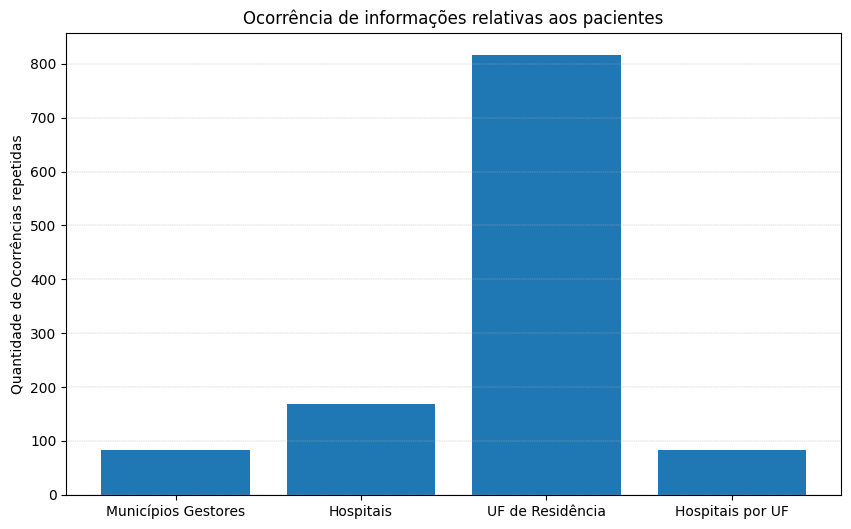

In [6]:
unique_uf = data_df['UF_ZI'].nunique()
unique_hospitals = data_df['CGC_HOSP'].nunique()
unique_residency_cities = data_df['MUNIC_RES'].nunique()
unique_hospital_cities = data_df['MUNIC_MOV'].nunique()

fig = plt.figure(figsize=(10,6))
plt.bar(['Municípios Gestores', 'Hospitais', 'UF de Residência', 'Hospitais por UF'],
        [unique_uf, unique_hospitals, unique_residency_cities, unique_hospital_cities])
plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Ocorrência de informações relativas aos pacientes")
plt.ylabel("Quantidade de Ocorrências repetidas")
# plt.xticks(rotation=45)
plt.show()

Há cerca de 12.52 pacientes por CEP.


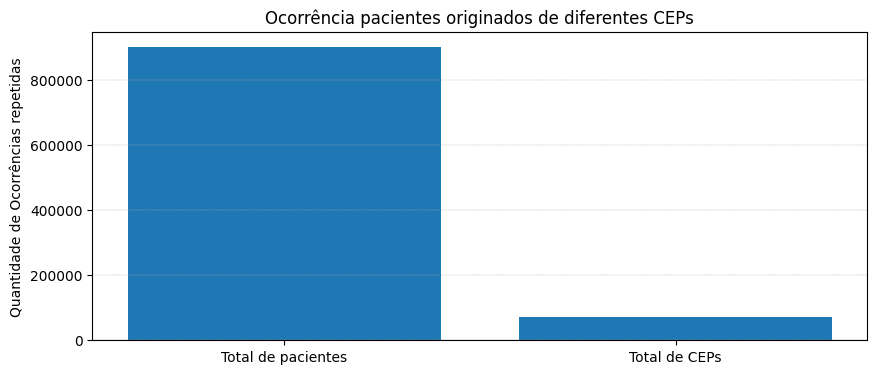

In [7]:
total_entries = data_df.shape[0]
unique_cep = data_df['CEP'].nunique()

print(f"Há cerca de {(total_entries / unique_cep):.2f} pacientes por CEP.")

fig = plt.figure(figsize=(10,4))
plt.bar(['Total de pacientes', 'Total de CEPs'],
        [total_entries, unique_cep])
plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Ocorrência pacientes originados de diferentes CEPs")
plt.ylabel("Quantidade de Ocorrências repetidas")
# plt.xticks(rotation=45)
plt.show()

In [8]:
'''
Função:
agrupar duas listas por grupos
de tamanho block_size.

values: lista com os índices
occurrencies: lista com os valores de cada índice
block_size: tamanho do bloco que será agrupado
'''
def group_lists(values, occurrencies, block_size=10):
    labels_list = []
    occurrencies_list = []

    for i in range(0, len(values), block_size):
        values_block = values[i:i + block_size]
        occurr_block = occurrencies[i:i + block_size]

        label = f"{values_block[0]}–{values_block[-1]}"
        total = sum(occurr_block)

        labels_list.append(label)
        occurrencies_list.append(total)

    return labels_list, occurrencies_list

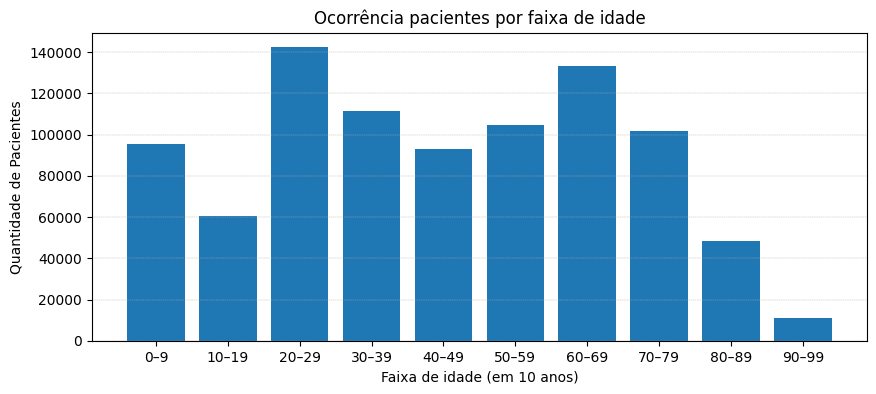

In [9]:
age_occurrencies = data_df['IDADE'].value_counts().sort_index()

age_list = age_occurrencies.index.tolist()
age_occurr_list = age_occurrencies.values.tolist()

age_blocks, age_occur_blocks = group_lists(age_list, age_occurr_list, 10)

fig = plt.figure(figsize=(10,4))
plt.bar(age_blocks, age_occur_blocks)
plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Ocorrência pacientes por faixa de idade")
plt.xlabel("Faixa de idade (em 10 anos)")
plt.ylabel("Quantidade de Pacientes")
# plt.xticks(rotation=45)
plt.show()

> Parece que a idade dos pacientes não é um fator de fácil identificação, pelo grande volume de pacientes no dataset. Todavia, ainda vale a pena explorar mais esses dados. Note há menos pacientes mais velhos em relação a pacientes numa faixa média de idade, porém o que isso implica? Talvez só existam menos pessoas de idades mais avançadas (80-99 anos, por exemplo).

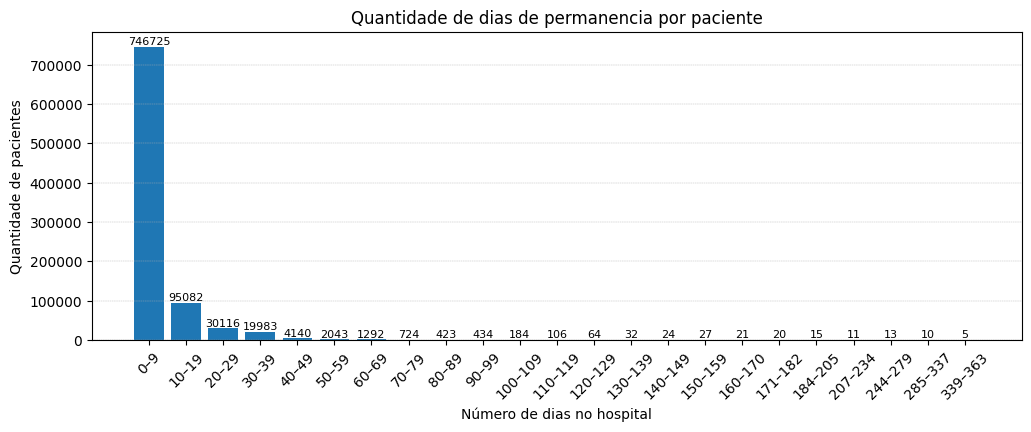

In [10]:
# como melhorar a visualização desse gráfico?
days_occurrencies = data_df['DIAS_PERM'].value_counts().sort_index()
# usar data_df['QT_DIARIAS'] dá um valor semelhante, esse deve ter pacientes que tiveram alta antes do previsto!

days_list = days_occurrencies.index.tolist()
days_occurr_list = days_occurrencies.values.tolist()

days_blocks, days_occur_blocks = group_lists(days_list, days_occurr_list, 10)

fig = plt.figure(figsize=(12,4))
bars = plt.bar(days_blocks, days_occur_blocks)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=8
    )

plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Quantidade de dias de permanencia por paciente")
plt.xlabel("Número de dias no hospital")
plt.ylabel("Quantidade de pacientes")
plt.xticks(rotation=45)
plt.show()

> Esse é um gráfico muito importante para se observar. Note que, conforme o número de dias de permanência no hospital vai crescendo, a quantidade de pacientes diminui drasticamente. Dessa forma, é fácil associar um paciente ao seu tempo de permanência, causando uma quebra em sua privacidade.

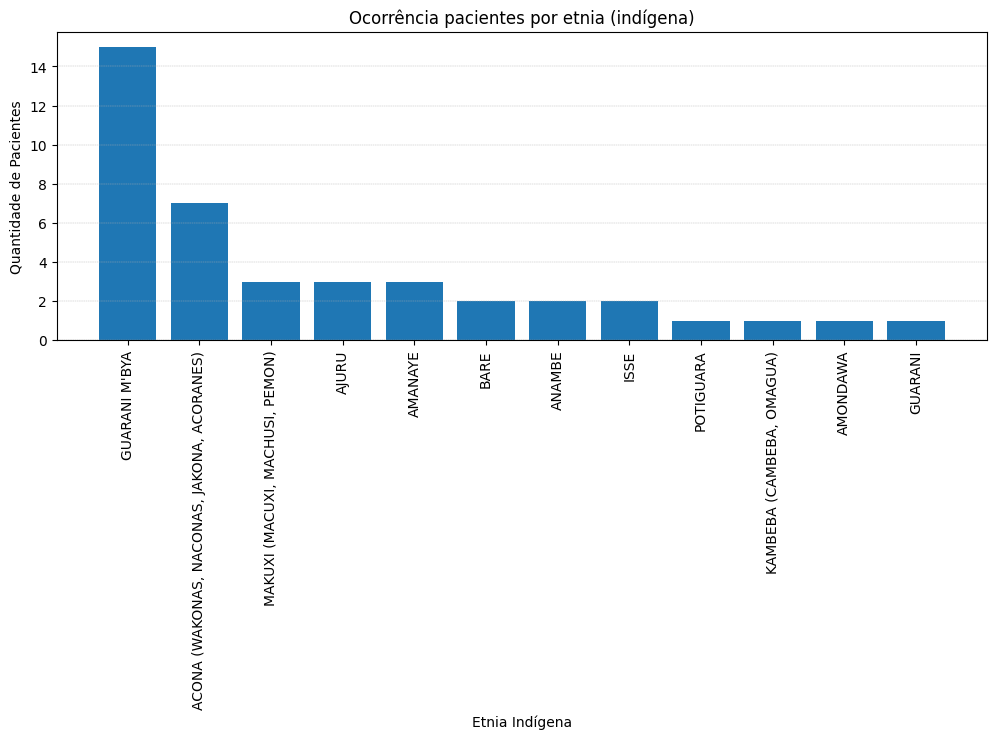

In [11]:
ethnicity_occurrencies = data_df['ETNIA'].value_counts()

ethnicity_list = ethnicity_occurrencies.index.tolist()[2:len(ethnicity_occurrencies)-1]
ethnicity_occurr_list = ethnicity_occurrencies.values.tolist()[2:len(ethnicity_occurrencies)-1]

fig = plt.figure(figsize=(12,4))
plt.bar(ethnicity_list, ethnicity_occurr_list)
plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Ocorrência pacientes por etnia (indígena)")
plt.xlabel("Etnia Indígena")
plt.ylabel("Quantidade de Pacientes")
plt.xticks(rotation=90)
plt.show()

> A raça/cor de uma pessoa pode ser um tipo de dado cuja divulgação seja sensível, porém, ao filtrarmos apenas pelos pacientes de acordo com suas etnias (indígenas), vemos que os pacientes são pouco diversos, tornando fácil a identificação (ex: tome pacientes Guarani. Há apenas um desses na lista, o que facilita sua identificação).

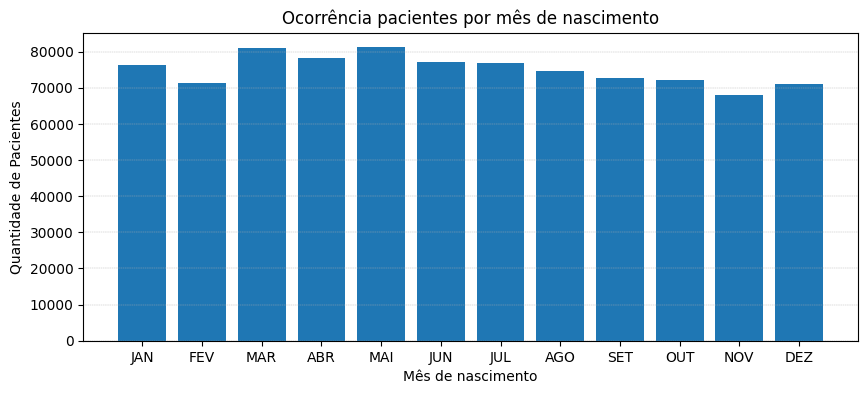

In [12]:
month_list = ['JAN', 'FEV', 'MAR', 'ABR', 'MAI', 'JUN', 'JUL', 'AGO', 'SET', 'OUT', 'NOV', 'DEZ']

birth_occurrencies = data_df['NASC'].dt.month.value_counts().sort_index()

birth_month_occurrencias = birth_occurrencies.values.tolist()

fig = plt.figure(figsize=(10,4))
plt.bar(month_list, birth_month_occurrencias)
plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Ocorrência pacientes por mês de nascimento")
plt.xlabel("Mês de nascimento")
plt.ylabel("Quantidade de Pacientes")
plt.show()

> Parece que não há um problema muito grande relacionado ao mês de nascimento dos pacientes. O problema maior é relacionado ao ano, que já foi explorado no gráfico de idade, e será representado a seguir novamente.

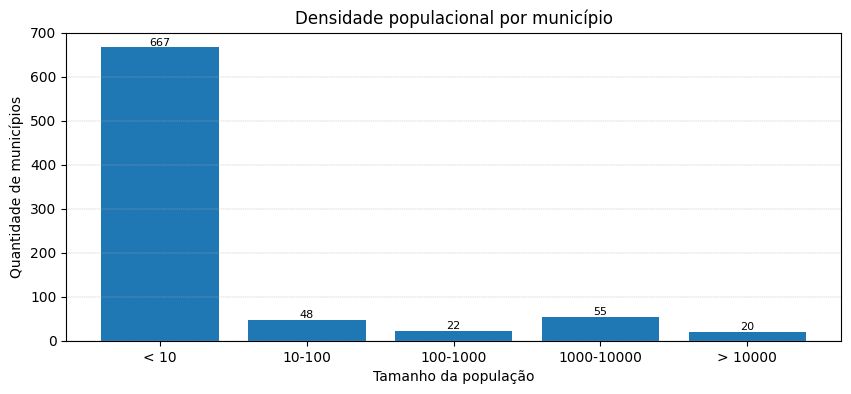

In [13]:
uf_occurrencies = data_df['MUNIC_RES'].value_counts().sort_values()

uf_occurr_list = uf_occurrencies.values.tolist()

population_density = ['< 10', '10-100', '100-1000', '1000-10000', '> 10000']
population_count = [0, 0, 0, 0, 0]

for item in uf_occurr_list:
    if item < 10:
        population_count[0] += 1
    if item > 10 and item <= 100:
        population_count[1] += 1
    if item > 100 and item <= 1000:
        population_count[2] += 1
    if item > 1000 and item <= 10000:
        population_count[3] += 1
    if item > 10000:
        population_count[4] += 1

fig = plt.figure(figsize=(10,4))
bars = plt.bar(population_density, population_count)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=8
    )

plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Densidade populacional por município")
plt.xlabel("Tamanho da população")
plt.ylabel("Quantidade de municípios")
plt.show()

> Aqui, há uma observação importante. Veja que há 812 municípios sendo analisados, mas 667 deles possui menos de 10 pacientes. Se analisarmos mais profundamente, vemos que mais de 300 municípios apresenta apenas um paciente.
>
> Esse representa um problema fortíssimo de privacidade que podemos tentar resolver, mas por esse número ser proporcionalmente alto, a chance de sacrificarmos qualidade dos dados deve ser bem alta também.

Há um total de 90 CEPs diferentes no formato XX*. Nosso gráfico ilustra 7 prefixos diferentes.


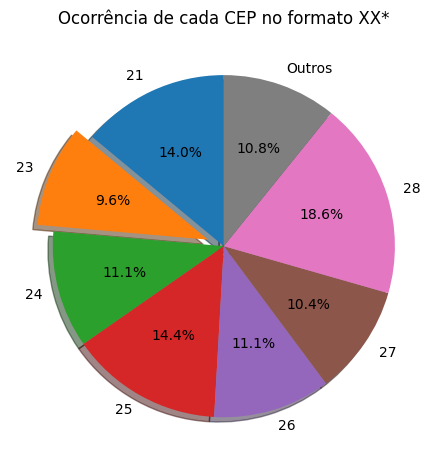

In [14]:
'''
O CEP é organizado da seguinte forma:

X0000-000: Região
0X000-000: Sub-região
00X00-000: Setor
000X0-000: Subsetor
0000X-000: Divisor de subsetor
00000-XXX: Sufixo de distribuição

Iremos manter os CEPs agrupados até Setor
'''

cep_df = data_df['CEP'].astype(str).str[:2]

cep_occurrencies = cep_df.value_counts().sort_index()

cep_list = cep_occurrencies.index.tolist()
cep_occurr_list = cep_occurrencies.values.tolist()

total = sum(cep_occurr_list)

# Filtra os que têm >= 10% do total e agrupa o resto em "Outros"
cep_filtrados = []
valores_filtrados = []
outros_valor = 0

for cep, valor in zip(cep_list, cep_occurr_list):
    percentual = 100 * valor / total
    if percentual >= 6:
        cep_filtrados.append(cep)
        valores_filtrados.append(valor)
    else:
        outros_valor += valor

if outros_valor > 0:
    cep_filtrados.append("Outros")
    valores_filtrados.append(outros_valor)

print(f"Há um total de {len(cep_list)} CEPs diferentes no formato XX*. Nosso gráfico ilustra {len(cep_filtrados)-1} prefixos diferentes.")


explode = [0] * len(cep_filtrados)
explode[1] = 0.1

# Plot do gráfico
fig, ax = plt.subplots()
ax.pie(
    valores_filtrados,
    explode=explode,
    labels=cep_filtrados,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90
)
plt.title("Ocorrência de cada CEP no formato XX*")
plt.tight_layout()
plt.show()


> Nesse gráfico, observamos que boa parte das pessoas vem de CEPs com o mesmo prefixo XX*. Note 10.8% das pessoas moram em CEPs listados em "outros", porém há mais de 80 CEPs registrados dessa forma. Isso se fixarmos o CEP apenas pelos dois primeiros dígitos (Região e Sub-região). Logo, a especificidade desse dado é gigante, e deve ser abordado na nossa análise de privacidade.

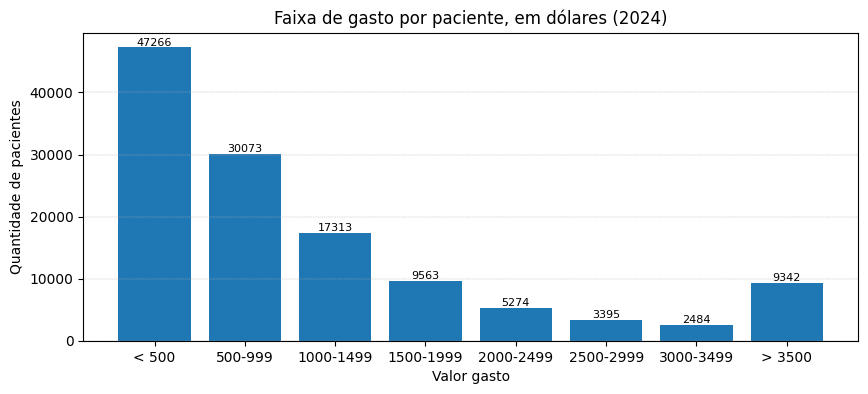

In [15]:
valueSpent_df = data_df['US_TOT']

valueSpentList = valueSpent_df.value_counts().sort_values()

values_list = [0] * 8
values_labels = ['< 500', '500-999', '1000-1499', '1500-1999', '2000-2499', '2500-2999', '3000-3499', '> 3500']

for value in valueSpentList.index.tolist():
    if value < 500:
        values_list[0] += 1
    if value >= 500 and value < 1000:
        values_list[1] += 1
    if value >= 1000 and value < 1500:
        values_list[2] += 1
    if value >= 1500 and value < 2000:
        values_list[3] += 1
    if value >= 2000 and value < 2500:
        values_list[4] += 1
    if value >= 2500 and value < 3000:
        values_list[5] += 1
    if value >= 3000 and value < 3500:
        values_list[6] += 1
    if value >= 3500:
        values_list[7] += 1

fig = plt.figure(figsize=(10,4))
bars = plt.bar(values_labels, values_list)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center', va='bottom', fontsize=8
    )

plt.grid(linestyle='--', axis='y', linewidth=0.3)
plt.title("Faixa de gasto por paciente, em dólares (2024)")
plt.xlabel("Valor gasto")
plt.ylabel("Quantidade de pacientes")
plt.show()

> Esse dado é extremamente sensível, pois pode ligar pacientes a renda que tiveram disponível para gastar em serviços médicos. O maior gasto foi na casa de 3800. Como podemos gerar mais privacidade em relação a isso?

Nos dados, podemos também analisar o país de origem de cada paciente, no campo `data_df['NACIONAL']`. Todavia, esse campo está mal definido, alguns países tem seu nome escrito, outros em o código no formato `0XX` e outros no formato `XX`.

Uma forma de corrigir isso seria acessando a [API de documentação dos países do IBGE](https://servicodados.ibge.gov.br/api/docs/paises), mas foge do escopo desse projeto. Note que, mesmo assim, uma análise muito mais cuidadosa dos dados seria necessária, dado que o nome de alguns países pode ter sido escrito errado, ou até mesmo de maneiras diferentes (por exemplo, variando letras maiúsculas), gerando mais de uma entrada na nossa tabela.

Assim, a princípio, se torna uma decisão de projeto não trabalhar com esses dados.

# Aplicando técnicas de privacidade

Após análises dos dados, decidimos manter as estatísticas de exemplo do enunciado, porém com uma noção melhor de como os dados do dataset são distribuídos.

## Differential Privacy

Total de casos por CID-10, por município, somando o valor total das consultas, separado por gênero. CID-10 é um código global de diagnóstico de doenças. Vamos focar no diagnóstico principal.

> DIAG_PRINC -> codigo do diagnostico principal (CID10)
>
> US_TOT -> valor total das consultas
>
> SEXO -> gênero do paciente
>
> MUNIC_RES -> município de residência do paciente

Escolhemos manter o município de residência do paciente pois torna mais fácil reidentificar o paciente, dado seu diagnóstico, sexo e município.

Primeiramente, começaremos explorando esses dados, para ter uma noção sobre esses campos, agrupando os dados conforme o enunciado pede, porém sem aplicar differential privacy. Após isso, iremos aplicar differential privacy nos dados do valor total das consultas (em dólares) e comparar os valores obtidos com os valores originais.

In [16]:
# Separando apenas os dados que queremos analisar
df = data_df.loc[:, ['DIAG_PRINC','US_TOT', 'SEXO', 'MUNIC_RES']]
df.head()

,DIAG_PRINC,US_TOT,SEXO,MUNIC_RES
0,S626,81.11,Masculino,330187
1,A418,200.76,Feminino,330490
2,K414,26.94,Masculino,330490
3,I500,161.70,Feminino,330490
4,G458,148.99,Masculino,330490


Como vimos anteriormente, há mais de 800 municípios no dataset, logo não faremos a visualização para todos.

Agora, é necessário agrupar os dados.

In [17]:
df_grouped = df.groupby(['MUNIC_RES', 'DIAG_PRINC', 'SEXO']).agg(
    VALOR_USD=('US_TOT', 'sum'),
    OCORRENCIAS=('US_TOT', 'count')
).reset_index()
df_grouped.head()

,MUNIC_RES,DIAG_PRINC,SEXO,VALOR_USD,OCORRENCIAS
0,110002,D171,Feminino,82.63,1
1,110002,Q251,Masculino,"2,047.78",1
2,110004,A319,Masculino,408.39,1
3,110004,N179,Masculino,344.87,1
4,110004,Q899,Masculino,88.97,1


Note que, nesses primeiros 5 casos, já temos um grande problema de privacidade sendo exposto. No município 110002, conseguimos identificar dois diagnósticos dados para dois pacientes diferentes, que identificamos o sexo e o valor pago na consulta.

Além do valor total em dólares ser um dado extremamente sensível, os outros dados são capazes de identificar o paciente, tendo em vista que só há uma ocorrência para cada diagnóstico.

## Análise de valor gasto por município

No eixo Y, mostramos qual foi o valor gasto (em dólares), em cada município, separado por sexo. Ordenamos a disposição dos dados pelo valor, na escala $\times 10^7$, em ordem decrescente, ou seja, das consultas mais caras para as mais baratas.

In [18]:
# Utility functions
def separate_df(df_grouped, columns_list, value_col_name, occur_col_name):
  result_df = df_grouped.groupby(columns_list).agg(
      VALOR_USD=(value_col_name, 'sum'),
      OCORRENCIAS=(occur_col_name, 'sum')
  ).reset_index()

  return result_df

def plot_analysis_bar_graphs(df, x, y, order, xlabel, ylabel, title):
  plt.figure(figsize=(14,6))

  sns.barplot(
      data=df,
      x=x,
      y=y,
      hue='SEXO',
      order=order
  )

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

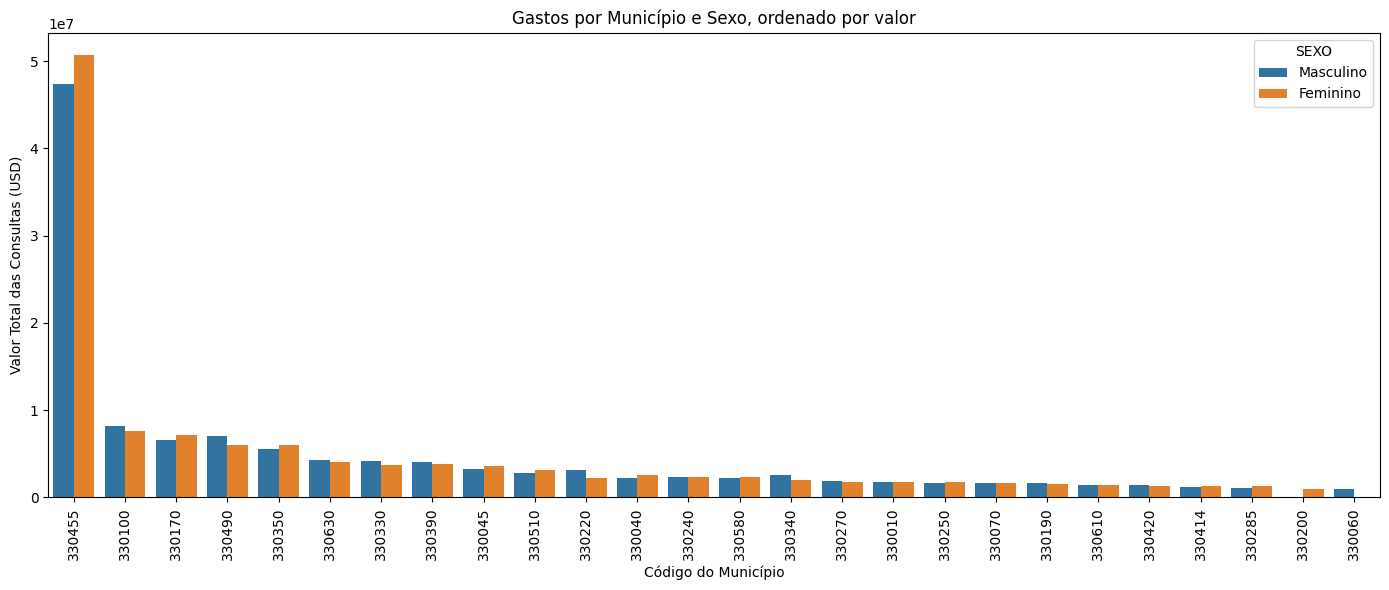

In [19]:
def valor_por_municipio(df_grouped, value_col_name, occur_col_name, ascending=False):
  df_municipio_sexo = separate_df(df_grouped, ['MUNIC_RES', 'SEXO'], value_col_name, occur_col_name)
  df_municipio_sexo_largest = df_municipio_sexo.nlargest(50, 'VALOR_USD')

  ordem_municipios = df_municipio_sexo_largest.groupby('MUNIC_RES')['VALOR_USD'].sum().sort_values(ascending=ascending).index

  plot_analysis_bar_graphs(
      df=df_municipio_sexo_largest,
      x='MUNIC_RES',
      y='VALOR_USD',
      order=ordem_municipios,
      xlabel='Código do Município',
      ylabel='Valor Total das Consultas (USD)',
      title='Gastos por Município e Sexo, ordenado por valor'
  )

valor_por_municipio(df_grouped, value_col_name='VALOR_USD', occur_col_name='OCORRENCIAS')

## Análise de pacientes por município

No eixo Y, mostramos qual foi a quantidade de pacientes que contribuíram com o valor total de pagamentos em dólares, em cada município representado no eixo X, separado por sexo.

Note que há muitos municípios com apenas um paciente. Esse é um grande problema de privacidade, pois torna os pacientes facilmente identificaveis.

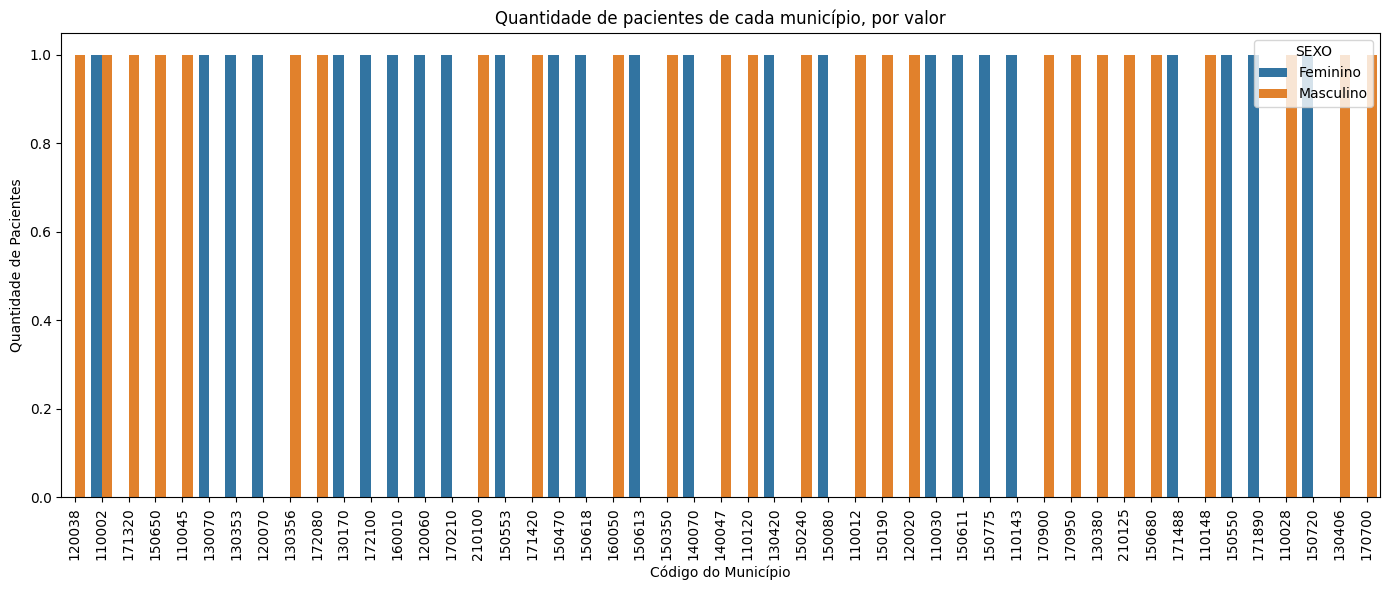

In [20]:
def pacientes_por_municipio(df_grouped, value_col_name, occur_col_name, ascending=False):
  df_municipio_sexo = separate_df(df_grouped, ['MUNIC_RES', 'SEXO'], value_col_name, occur_col_name)
  df_municipio_sexo_smallest = df_municipio_sexo.nsmallest(50, 'OCORRENCIAS')

  ordem_municipios_ocorrencias = df_municipio_sexo_smallest.groupby('MUNIC_RES')['VALOR_USD'].sum().sort_values(ascending=ascending).index

  plot_analysis_bar_graphs(
      df=df_municipio_sexo_smallest,
      x='MUNIC_RES',
      y='OCORRENCIAS',
      order=ordem_municipios_ocorrencias,
      xlabel='Código do Município',
      ylabel='Quantidade de Pacientes',
      title='Quantidade de pacientes de cada município, por valor'
  )

pacientes_por_municipio(df_grouped, value_col_name='VALOR_USD', occur_col_name='OCORRENCIAS')

## Análise de valor gasto por diagnóstico

No eixo Y, mostramos qual foi o valor gasto (em dólares), por diagnóstico, separado por sexo. Ordenamos a disposição dos dados pelo valor, na escala $\times 10^6$, em ordem decrescente, ou seja, das consultas mais caras para as mais baratas.

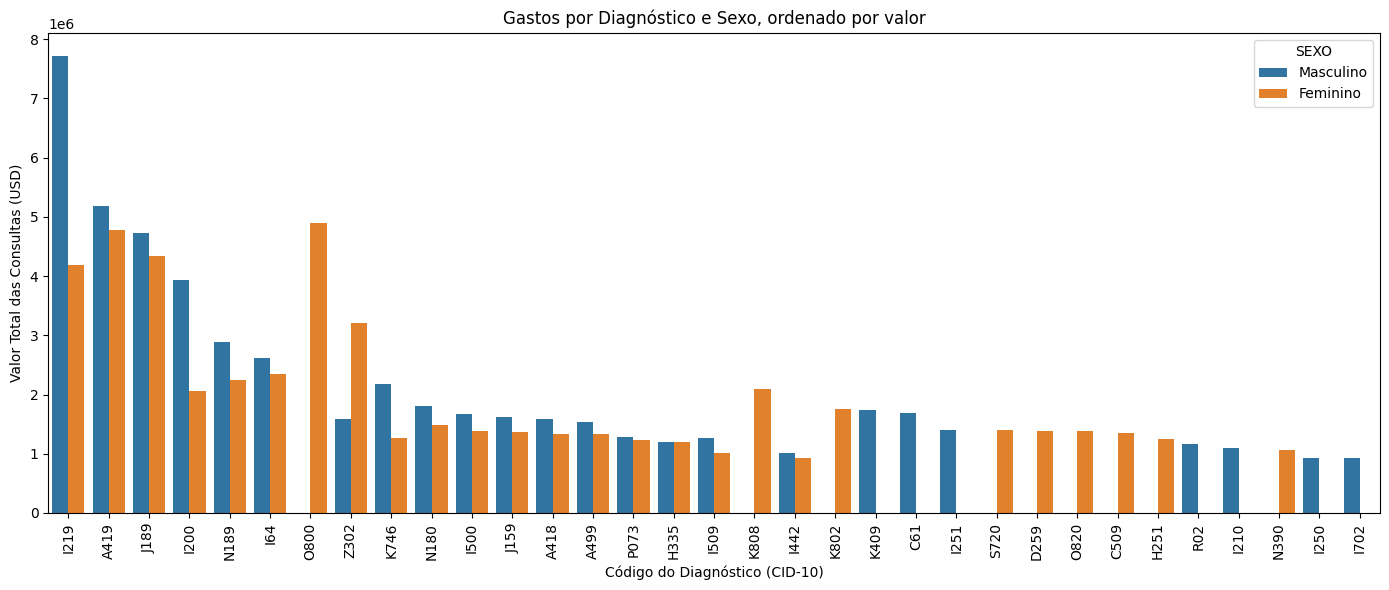

In [21]:
def valor_por_diagnostico(df_grouped, value_col_name, occur_col_name, ascending=False):
  df_diagnostico_sexo = separate_df(df_grouped, ['DIAG_PRINC', 'SEXO'], value_col_name, occur_col_name)
  df_diagnostico_sexo_largest = df_diagnostico_sexo.nlargest(50, 'VALOR_USD')

  ordem_diagnostico = df_diagnostico_sexo_largest.groupby('DIAG_PRINC')['VALOR_USD'].sum().sort_values(ascending=ascending).index

  plot_analysis_bar_graphs(
      df=df_diagnostico_sexo_largest,
      x='DIAG_PRINC',
      y='VALOR_USD',
      order=ordem_diagnostico,
      xlabel='Código do Diagnóstico (CID-10)',
      ylabel='Valor Total das Consultas (USD)',
      title='Gastos por Diagnóstico e Sexo, ordenado por valor'
  )

valor_por_diagnostico(df_grouped, value_col_name='VALOR_USD', occur_col_name='OCORRENCIAS')

## Análise de pacientes por diagnóstico

No eixo Y, mostramos qual foi a quantidade de pacientes, contribuindo com o pagamento total, para cada diagnóstico (eixo X), separado por sexo.

Novamente, podemos identificar os pacientes por diagnóstico, visto que, para cada paciente, o diagnóstico pode ser único.

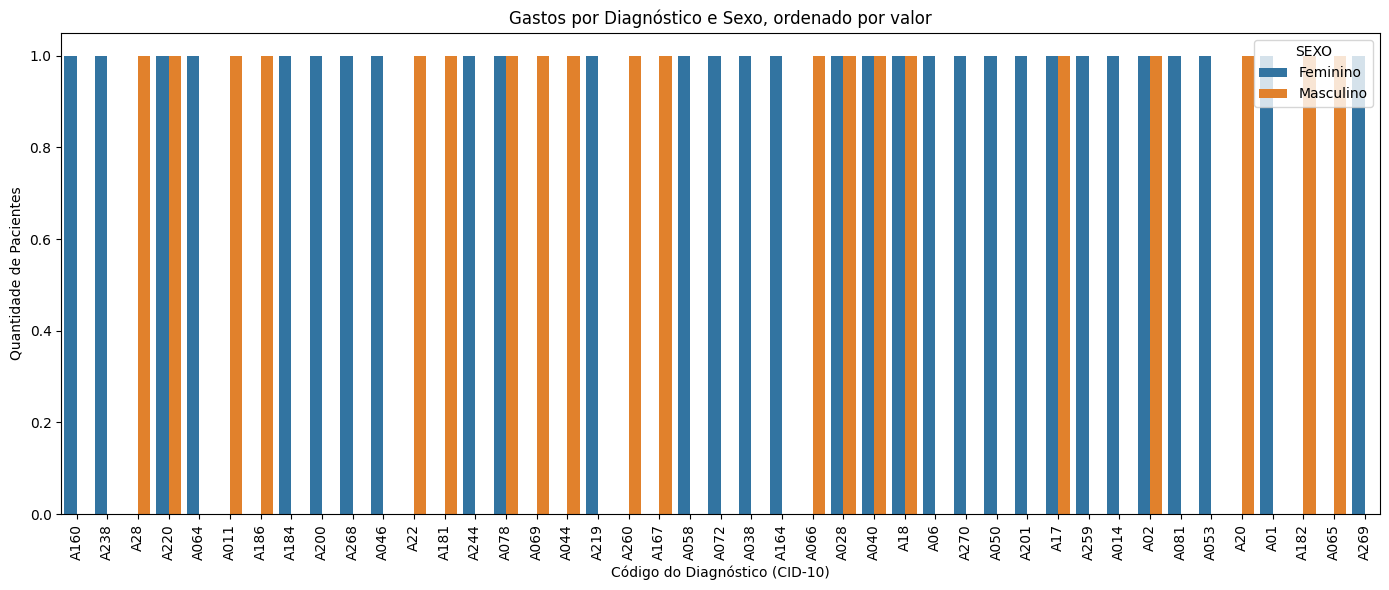

In [22]:
def pacientes_por_diagnostico(df_grouped, value_col_name, occur_col_name, ascending=False):
  df_diagnostico_sexo = separate_df(df_grouped, ['DIAG_PRINC', 'SEXO'], value_col_name, occur_col_name)
  df_diagnostico_sexo_smallest = df_diagnostico_sexo.nsmallest(50, 'OCORRENCIAS')

  ordem_diagnostico = df_diagnostico_sexo_smallest.groupby('DIAG_PRINC')['VALOR_USD'].sum().sort_values(ascending=ascending).index

  plot_analysis_bar_graphs(
      df=df_diagnostico_sexo_smallest,
      x='DIAG_PRINC',
      y='OCORRENCIAS',
      order=ordem_diagnostico,
      xlabel='Código do Diagnóstico (CID-10)',
      ylabel='Quantidade de Pacientes',
      title='Gastos por Diagnóstico e Sexo, ordenado por valor'
  )

pacientes_por_diagnostico(df_grouped, value_col_name='VALOR_USD', occur_col_name='OCORRENCIAS')

### Aplicando Differential Privacy


In [23]:
ops = pipeline_dp.LocalBackend()

In [24]:
# adicionar id para cada paciente
df['patient_id'] = df.index.astype(str)
df.head()

,DIAG_PRINC,US_TOT,SEXO,MUNIC_RES,patient_id
0,S626,81.11,Masculino,330187,0
1,A418,200.76,Feminino,330490,1
2,K414,26.94,Masculino,330490,2
3,I500,161.70,Feminino,330490,3
4,G458,148.99,Masculino,330490,4


É importante visualizar a distribuição dos dados de valor pago em dólares para escolher o parâmetro `max_value` que cada paciente contribui na sensibilidade dos dados, ao aplicar DP.

Nessa visualização, a maior parte dos dados tem valores de consulta baixos, logo manteremos nosso upper bound entre 300-700. Note que, ao manter o range de lower bound e upper bound mais baixo, sacrificamos um pouco de privacidade, mas preservamos a qualidade dos dados.

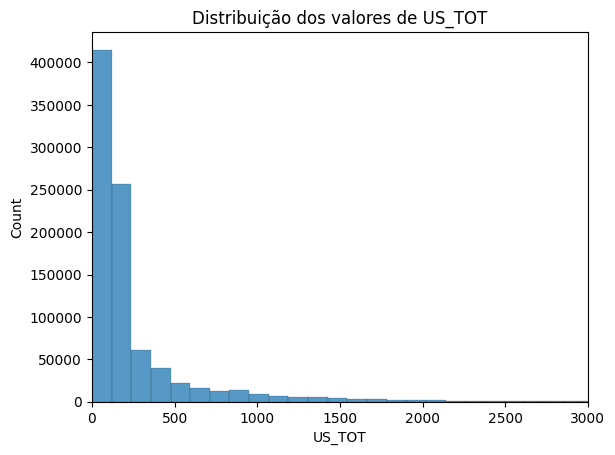

In [25]:
sns.histplot(df['US_TOT'], bins=300)
plt.xlim(0, 3000)  # ou ajuste conforme necessário pra ver melhor a cauda
plt.title("Distribuição dos valores de US_TOT")
plt.show()

In [26]:
'''
Function: run differential privacy
pipeline on original data.

This function applies dp on the data
according to the parameters, and join specific fields
from the dataframe.
'''
def run_pipeline(data,
                 ops,
                 total_epsilon=1,
                 total_delta=1e-9,
                 public_partitions=None):
  budget_accountant = pipeline_dp.NaiveBudgetAccountant(
      total_epsilon=total_epsilon, total_delta=total_delta
  )

  dp_engine = pipeline_dp.DPEngine(budget_accountant, ops)

  params = pipeline_dp.AggregateParams(
      noise_kind=pipeline_dp.NoiseKind.LAPLACE,
      metrics=[pipeline_dp.Metrics.SUM, pipeline_dp.Metrics.COUNT],
      max_partitions_contributed=1,
      max_contributions_per_partition=1,
      min_value=0,
      max_value=400
  )

  data_extractors = pipeline_dp.DataExtractors(
      privacy_id_extractor=lambda row: row['patient_id'],
      partition_extractor=lambda row: (row['MUNIC_RES'], row['DIAG_PRINC'], row['SEXO']),
      value_extractor=lambda row: row['US_TOT']
  )

  dp_result = dp_engine.aggregate(data, params, data_extractors, public_partitions)

  budget_accountant.compute_budgets()

  return dp_result

In [27]:
rows = [index_row[1] for index_row in df.iterrows()]

dp_result_local = run_pipeline(
    rows, ops, total_delta=1/len(rows)
)
dp_result_local = list(dp_result_local)

In [28]:
dp_result_df = pd.DataFrame([{
    'MUNIC_RES': r[0][0],
    'DIAG_PRINC': r[0][1],
    'SEXO': r[0][2],
    'VALOR_USD_DP': r[1].sum,
    'OCORRENCIAS_DP': r[1].count
} for r in dp_result_local])

# clip negative values to 0
dp_result_df['VALOR_USD_DP'] = dp_result_df['VALOR_USD_DP'].clip(lower=0)
dp_result_df['OCORRENCIAS_DP'] = dp_result_df['OCORRENCIAS_DP'].clip(lower=0)

In [29]:
print(dp_result_df.sort_values(by='VALOR_USD_DP', ascending=True).head())
print(df_grouped.sort_values(by='VALOR_USD', ascending=True).head())

      MUNIC_RES DIAG_PRINC       SEXO  VALOR_USD_DP  OCORRENCIAS_DP
3190     330480       O200   Feminino          0.00           47.94
2761     330455       N906   Feminino          0.00           87.42
1351     330023       F208   Feminino          0.00           49.07
1403     330040       F239  Masculino          0.00           56.61
1454     330040       F238  Masculino          0.00           44.22
       MUNIC_RES DIAG_PRINC       SEXO  VALOR_USD  OCORRENCIAS
82524     330455       F001  Masculino       0.00           15
27307     330170        F54  Masculino       0.00            1
27306     330170        F53   Feminino       0.00            1
72117     330411        G40  Masculino       0.00            1
27305     330170       F505   Feminino       0.00            1


## Comparando resultados obtidos

Primeiramente, comparamos os gastos clínicos agrupados por município, diagnóstico e sexo.

Em seguida, iremos gerar gráficos semelhantes aos que geramos anteriormente, para dados não anonimizados.

In [30]:
def comparar_resultados(df_valores, ascending=False):
  df_plot_valores = df_valores.sort_values('VALOR_USD', ascending=ascending).head(30)

  df_long_valores = df_plot_valores.melt(
      id_vars=['MUNIC_RES', 'DIAG_PRINC', 'SEXO'],
      value_vars=['VALOR_USD', 'VALOR_USD_DP'],
      var_name='Tipo',
      value_name='Valor'
  )

  df_long_valores['Grupo'] = (
      df_long_valores['MUNIC_RES'].astype(str) + ' | ' +
      df_long_valores['DIAG_PRINC'] + ' | ' +
      df_long_valores['SEXO']
  )

  plt.figure(figsize=(14, 6))
  sns.barplot(
      data=df_long_valores,
      x='Grupo',
      y='Valor',
      hue='Tipo'
  )

  plt.xticks(rotation=90)
  plt.xlabel('Município | Diagnóstico | Sexo')
  plt.ylabel('Valor Total das Consultas (USD)')
  plt.title('Comparação de Gastos: Original vs Differential Privacy')
  plt.tight_layout()
  plt.show()

## Comparando gastos, para todos parâmetros, com dp, (decrescente)

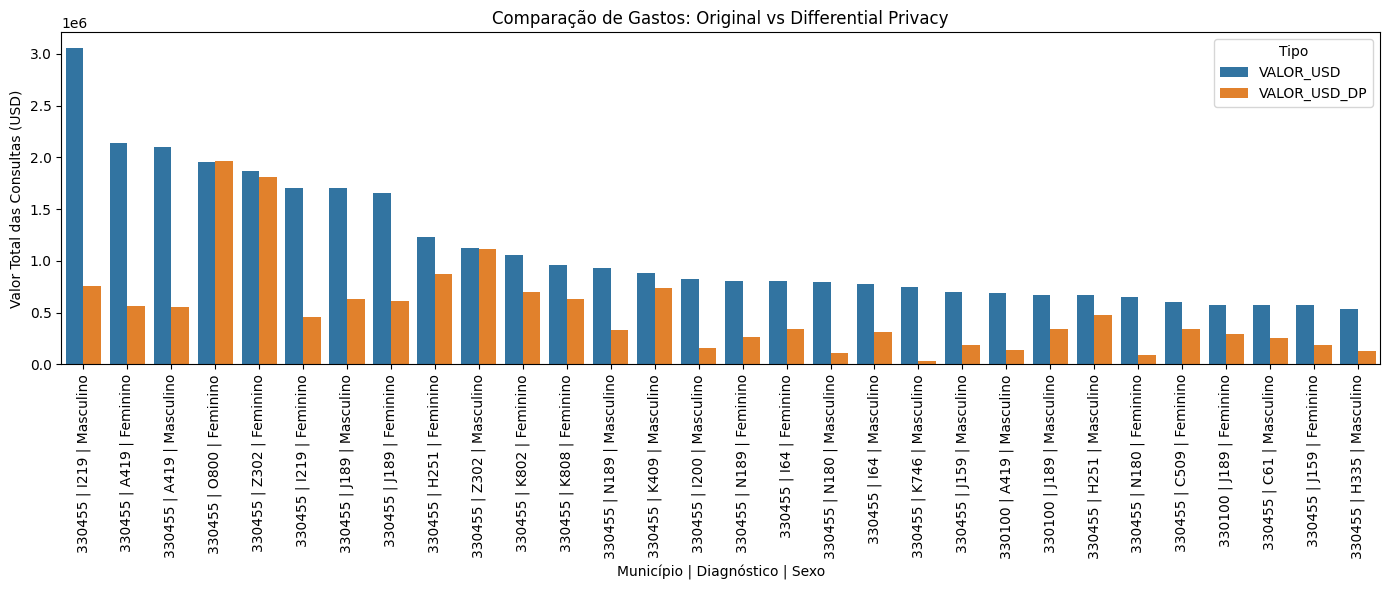

In [31]:
df_valores = pd.merge(
    df_grouped,
    dp_result_df[['MUNIC_RES', 'DIAG_PRINC', 'SEXO', 'VALOR_USD_DP']],
    on=['MUNIC_RES', 'DIAG_PRINC', 'SEXO'],
    how='inner'
)

comparar_resultados(df_valores, ascending=False)

## Comparando gastos, para todos parâmetros, com dp, (crescente)

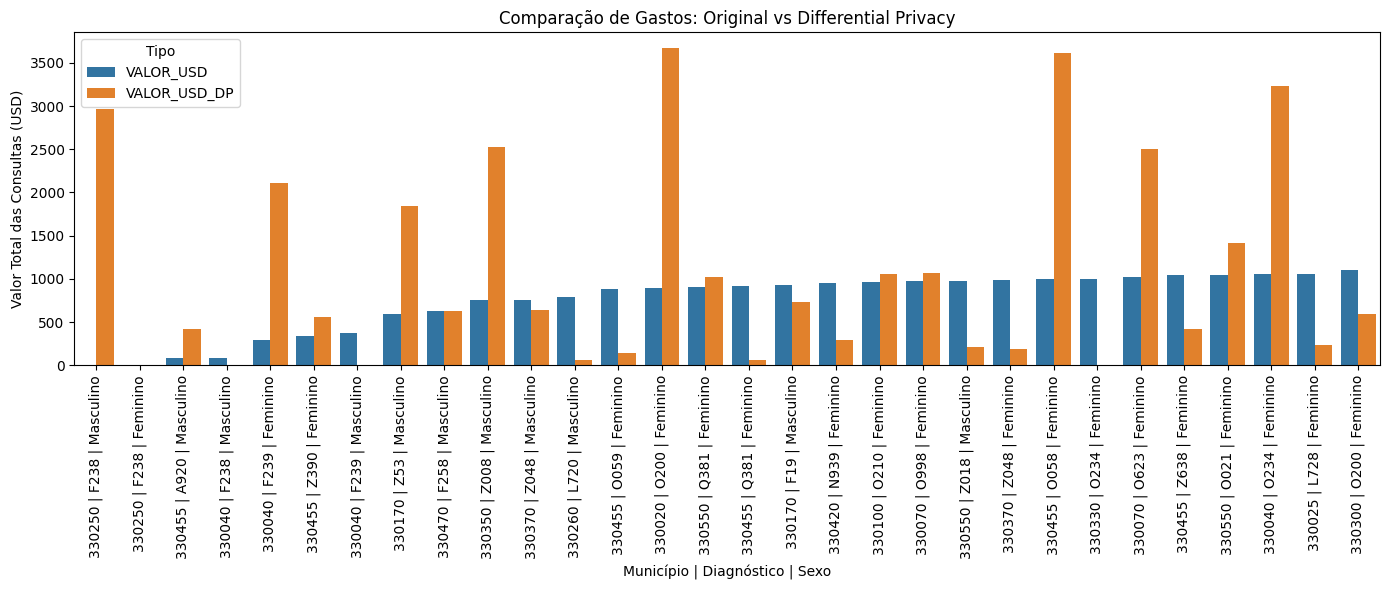

In [32]:
comparar_resultados(df_valores, ascending=True)

## Análise de valor gasto por município com DP

Aqui, repetimos a análise que havíamos feito anteriormente nos dados não anonimizados. Repare que o gráfico ainda mantém informação para análise, porém os valores em dólares são muito menores.

Aqui, apresentamos um risco menor de expor grandes gastos financeiros em dados médicos.

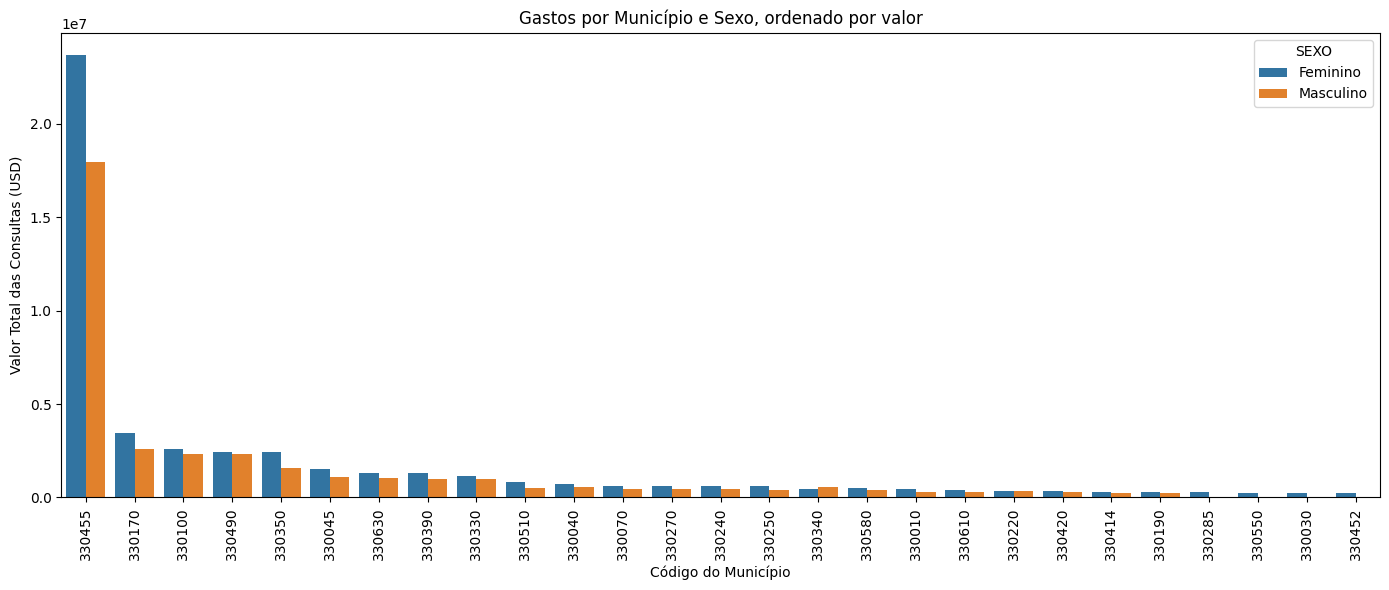

In [33]:
valor_por_municipio(dp_result_df, value_col_name='VALOR_USD_DP', occur_col_name='OCORRENCIAS_DP')

## Análise de pacientes por município com DP

Anteriormente, ao fazer essa análise de quantos pacientes contribuíam para cada dado financeiro, e ordenando os dados de maneira crescente, obtínhamos vários casos em que apenas 1 paciente era responsável pelos valores clínicos.

Após aplicar differential privacy, temos que esses valores cresceram muito, o que reflete um bom fator de anonimização, porém não tão bom para manutenção dos registros originais do dataset.

Assim, é possível, para esse problema, modificar os parâmetros utilizados na geração dos dados anonimizados.


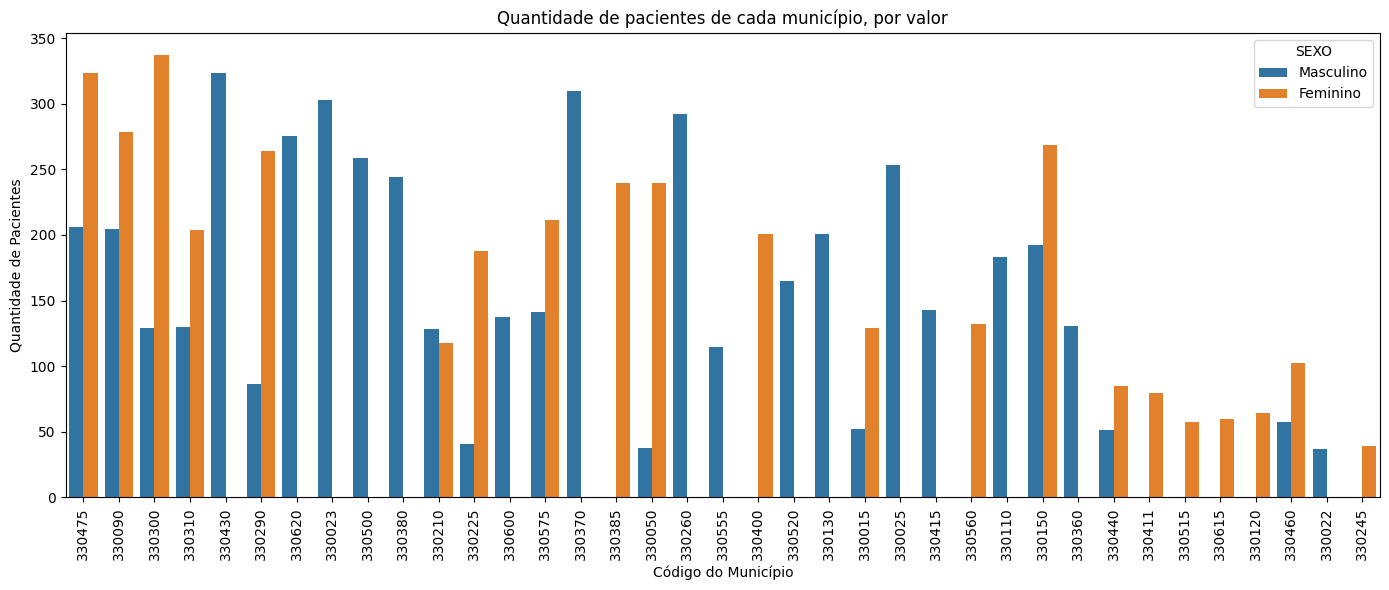

In [34]:
pacientes_por_municipio(dp_result_df, value_col_name='VALOR_USD_DP', occur_col_name='OCORRENCIAS_DP')

## Análise de valor gasto por diagnóstico com DP

Aqui, novamente comparando com as medidas obtidas sem DP, temos valores que ainda refletem bem o padrão dos dados originais, mas com valores escalavelmente menores.

Assim, se torna mais difícil identificar que diagnóstico médico pode resultar em valores maiores e exorbitantes, e gerando resultados positivos quanto a anonimização dos dados para valores financeiros altos.


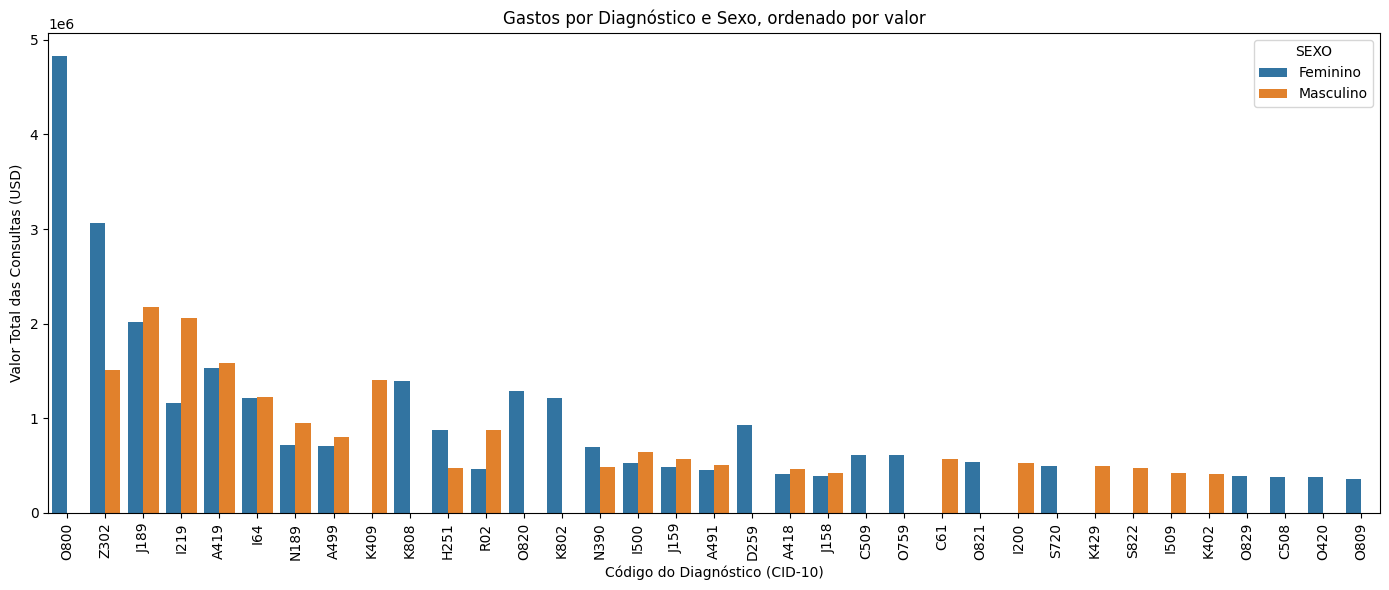

In [35]:
valor_por_diagnostico(dp_result_df, value_col_name='VALOR_USD_DP', occur_col_name='OCORRENCIAS_DP')

## Análise de pacientes por diagnóstico com DP

Anteriormente, tínhamos um gráfico que mostrava apenas 1 paciente por diagnóstico, e poderia apresentar muitos dados que o único paciente era do sexo masculino ou feminino.

Agora, nosso gráfico mostra que os dados estão anonimizados, tornando difícil a identificação de pacientes que foram diagnosticados com uma enfermidade específica.

Note que, novamente, essa anonimização foi muito forte e não reflete os melhores resultados para manutenção da qualidade dos dados, mas é extremamente relevante na anonimização dos pacientes.


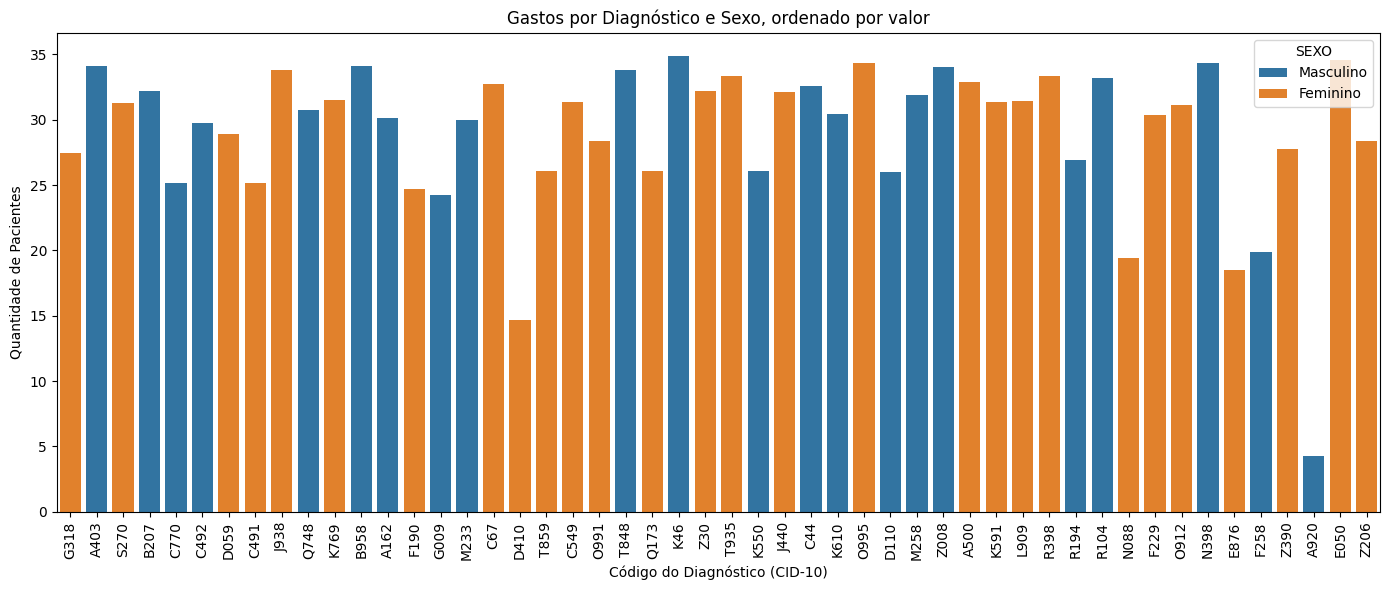

In [36]:
pacientes_por_diagnostico(dp_result_df, value_col_name='VALOR_USD_DP', occur_col_name='OCORRENCIAS_DP')

## Conclusões da comparação

Note que, ao aplicar differential privacy nos dados da soma dos valores, temos que os dados de fato foram modificados e anonimizados.

Nesse contexto, ao observarmos os valores clínicos mais baixos para o agrupamento de município, diagnóstico e sexo, temos que o noise gerado foi mais efetivo, havendo muita variação entre os valores originais e os valores com differential privacy. Por outro lado, ao analisarmos com os valores clínicos mais altos, a aplicação de differential privacy foi eficiente em remover outliers, valores que estavam muito acima do restante (mesmo entre os mais altos).

Além disso, conseguimos, com differential privacy, anonimizar fortemente os dados dos pacientes individuais, como comprovado nos últimos 4 gráficos gerados, mesmo que tenhamos comprometido, em partes, a qualidade do nosso dataset.

Assim, como escolhemos não adicionar tanto noise e manter qualidade dos dados, concluímos que a aplicação de differential privacy foi eficiente para anonimizar valores clínicos altos, que ainda ocorrem, no geral, na mesma cidade, porém representam valores muito mais baixos e com menor variância, o que não deve comprometer a privacidade dos pacientes.